In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox

(0) Load

In [2]:
path = '/Users/robertpinochetgomez/GitHub/time-series-analysis/00-data'

df_exports = pd.read_parquet(f'{path}/df_nsc_2025_until_w18.parquet')
df_exports['Week'] = df_exports['Week'].astype('int32')
df_exports.tail()

,Country,Volume (KG),Kr/kg,Week,Product,Year,Continent
8512,EU27,377,151.62,16,FROZEN FILLETS,2025,EUROPE
8513,TOTALT,1211,151.31,17,FROZEN FILLETS,2025,UNCLASSIFIED
8514,EU27,432,143.34,17,FROZEN FILLETS,2025,EUROPE
8515,TOTALT,1423,147.68,18,FROZEN FILLETS,2025,UNCLASSIFIED
8516,EU27,653,148.88,18,FROZEN FILLETS,2025,EUROPE


(2) Build SARIMA Model

In [3]:
# df_exports['Year-Week'] = df_exports['Year'].astype('string') + '-' + df_exports['Week'].astype('string')

df_totalt = (df_exports.loc[df_exports['Country'].isin(['TOTALT'])]).groupby(by=['Year', 'Week']).agg(
                                                        VolumeKG = ('Volume (KG)', 'sum')
)

df_totalt['Volume_Box_Cox'], lam = boxcox(df_totalt['VolumeKG'])

train = df_totalt.iloc[:-int(len(df_totalt) * 0.15) ]
test = df_totalt.iloc[-int(len(df_totalt) * 0.15):]

# Fit the model (note the lowercase 'model' in the import path)
model = ARIMA(train['Volume_Box_Cox'], order=(2, 1, 44), seasonal_order=(1, 1, 1, 52))
model_fit = model.fit()

# Forecast
volume_forecast = model_fit.forecast(steps=len(test))

# Inverse Box-Cox transformation
forecasts = inv_boxcox(volume_forecast, lam)

/Users/robertpinochetgomez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/robertpinochetgomez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/robertpinochetgomez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/robertpinochetgomez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting p

In [4]:
# Crear el DataFrame con las predicciones y el índice que ya tiene (Year, Week)
forecasts_df = pd.DataFrame({
    'Forecast': forecasts,
    'Index': test.index  # Index es un MultiIndex de la forma (Year, Week)
})

# Separar el índice en columnas Year y Week
forecasts_df[['Year', 'Week']] = pd.DataFrame(forecasts_df['Index'].tolist(), index=forecasts_df.index)

# Eliminar la columna 'Index'
forecasts_df = forecasts_df.drop(columns='Index')

# Realizar el merge con df_totalt
merge_df = df_totalt.merge(forecasts_df, on=['Year', 'Week'], how='left').set_index(['Year', 'Week'])

(3) Results

<Axes: title={'center': 'SARIMA Results'}, xlabel='Year,Week'>

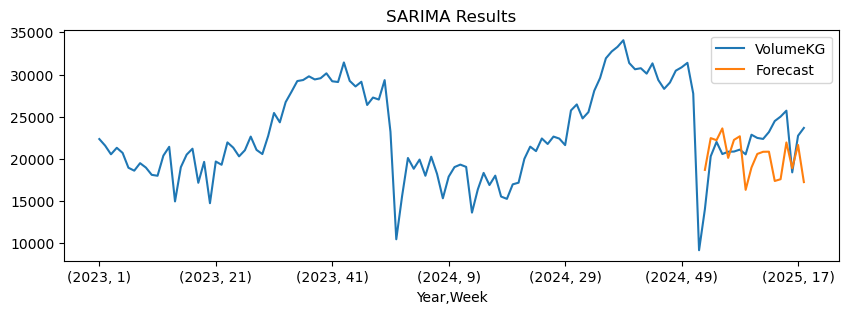

In [5]:
merge_df.drop(columns='Volume_Box_Cox').plot(kind='line', title='SARIMA Results', figsize=(10,3))

Conclusión: Esto es interesante, dado que lo que ocurrió en las exportaciones de noruega para los comienzos del 2025, fue un superavit de oferta, dado a buenas condiciones biológicas. Pero la estimación, sin saber de esta sobre oferta, no la modeló, porque obviamente siguió el patrón de las estacionalidades pasadas. Por lo que podemos decir, que la sobreoferta fue efectivamente un outlier dentro del fenómeno.
Ahora me surge la siguiente pregunta... para pronosticar, es correcto considerar solo una variable?